# Dimension reduction for data visualization

Non-linear dimension reductiona and clustering is a powerful tool to very fastly see where are the most significant differences between different spectra and what is driving these differences. 
We propose here to use UMAP as a dimension reduction algorithm and plot the 2D representation for different scenarios.
We will start exactly like we did in the other notebook (data_analysis_with_pypam), so we can make sure we have the HMD downloaded.

## 0. Setup (install)

First we need to install all the packages which we need to exectue this notebook. You don't need to do this if you're using mybinder

In [1]:
!pip install pvlib # This one is optional for the summary plot! 
!pip install git+https://github.com/lifewatch/pypam@feature/hmb_to_octaves # install pypam's latest version (from github)
!pip install minio # Install package to download the process

  Cloning https://github.com/lifewatch/pypam (to revision feature/hmb_to_octaves) to /tmp/pip-req-build-b_4dkl3f
  Running command git clone --filter=blob:none --quiet https://github.com/lifewatch/pypam /tmp/pip-req-build-b_4dkl3f
  Running command git checkout -b feature/hmb_to_octaves --track origin/feature/hmb_to_octaves
  Switched to a new branch 'feature/hmb_to_octaves'
  Branch 'feature/hmb_to_octaves' set up to track remote branch 'feature/hmb_to_octaves' from 'origin'.
  Resolved https://github.com/lifewatch/pypam to commit 027b81c780dc6ac712e4fe8d160097d0165aa357
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## 1. Download the data

We will download some processed HMB data stored in the cloud to give some examples of how can it be used. 
These data will be downloaded in this jupyterlab space, and you will be able to find them under the folder you specify here below, organized by station. 
Please change this line depending on where you want to store the data. 

We first start importing the packages we need for this part of the notebook

In [2]:
# Import the necessary packages
import minio
import os
import pathlib
from datetime import datetime

In [3]:
local_path = '../data'
max_days = 100
start_date_time = '2021-01-01'
end_date_time = '2021-02-01'

In [4]:
# Update end_date_time if defined temporal range exceeds max_days
time_delta = datetime.fromisoformat(end_date_time) - datetime.fromisoformat(start_date_time)
if time_delta.days > max_days:
    end_date_time = str(datetime.fromisoformat(start_date_time) + timedelta(days=max_days))
    print(f'end_date_time updated to {end_date_time}')

We will then start defining a function to download the data ONLY from the period we are interested in which can be then reused for different stations (then we don't need to write as much!)

In [5]:
# First we create a function to download data 
def download_data_station(station_name, 
                          client_obj, 
                          bucket_str, 
                          prefix_str, 
                          data_path,
                          name_format,
                          start_datetime, 
                          end_datetime):
    start_datetime_obj = datetime.fromisoformat(start_datetime) 
    end_datetime_obj = datetime.fromisoformat(end_datetime)
    station_folder = pathlib.Path(data_path).joinpath(station_name)
    if not station_folder.exists():
        os.mkdir(station_folder)
    objects = list(client_obj.list_objects(bucket_str, prefix=prefix_str))
    ct = 0
    for i, obj in enumerate(objects):
        object_name = obj.object_name
        path_name = pathlib.Path(object_name).name
        if (not path_name.startswith('.')) & path_name.endswith('.nc'):
            file_date = datetime.strptime(path_name, name_format)
            if (file_date >= start_datetime_obj) & (file_date <= end_datetime_obj):
                download_path = data_path + '/' + station_name + '/' + pathlib.Path(object_name).name
                if os.path.isfile(download_path):
                    print('Already downloaded: ' + download_path)
                else:
                    print('Download ' + str(ct) + ' of ' + str(len(objects)) + ': ' + download_path)
                    object_data = client.get_object(bucket, object_name)
                    if not os.path.isdir(download_path):
                        with open(str(download_path), 'wb') as file_data:
                            for data in object_data:
                                file_data.write(data)
                    file_data.close()
            else: 
                print('Ignored, out of selected period or not a netCDF file ' + path_name)
        ct += 1

Then we will download the data for 2 stations. 
For this workshop we have chosen MARS and NRS11, but feel free to change the station names here if you wish to play around with other stations from the same providers

Let's start with MARS. We first need to describe where the data are located

In [6]:
# Set up the download for MARS data
client = minio.Minio( "s3.us-west-2.amazonaws.com", secure=False)

bucket = 'pacific-sound-spectra'
prefix = '2021/'
station = 'MARS'
name_format = 'MARS_%Y%m%d.nc'
download_data_station(station, client, bucket, prefix, local_path, name_format=name_format, start_datetime=start_date_time, end_datetime=end_date_time)

Download 2 of 711: ../data/MARS/MARS_20210101.nc
Download 4 of 711: ../data/MARS/MARS_20210102.nc
Download 6 of 711: ../data/MARS/MARS_20210103.nc
Download 8 of 711: ../data/MARS/MARS_20210104.nc
Download 10 of 711: ../data/MARS/MARS_20210105.nc
Download 12 of 711: ../data/MARS/MARS_20210106.nc
Download 14 of 711: ../data/MARS/MARS_20210107.nc
Download 16 of 711: ../data/MARS/MARS_20210108.nc
Download 18 of 711: ../data/MARS/MARS_20210109.nc
Download 20 of 711: ../data/MARS/MARS_20210110.nc
Download 22 of 711: ../data/MARS/MARS_20210111.nc
Download 24 of 711: ../data/MARS/MARS_20210112.nc
Download 26 of 711: ../data/MARS/MARS_20210113.nc
Download 28 of 711: ../data/MARS/MARS_20210114.nc
Download 30 of 711: ../data/MARS/MARS_20210115.nc
Download 32 of 711: ../data/MARS/MARS_20210116.nc
Download 34 of 711: ../data/MARS/MARS_20210117.nc
Download 36 of 711: ../data/MARS/MARS_20210118.nc
Download 38 of 711: ../data/MARS/MARS_20210119.nc
Download 40 of 711: ../data/MARS/MARS_20210120.nc
Down

Then we move to the NRS11 data. We repreat the same process just with different parameters.
These are the data we can find at [sanctsound](https://console.cloud.google.com/storage/browser/noaa-passive-bioacoustic/sanctsound?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false), daily millidecade bands. 

In [7]:
# Set up the download for NRS11 data 
client = minio.Minio('storage.googleapis.com')
bucket = 'noaa-passive-bioacoustic'
station = 'NRS11'
prefix = 'soundcoop/%s/' % station
name_format = 'NRS11_H5R6.1.5000_%Y%m%d_DAILY_MILLIDEC_MinRes_v2.nc'
download_data_station(station, client, bucket, prefix, local_path, name_format=name_format, start_datetime=start_date_time, end_datetime=end_date_time)

Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191023_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191024_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191025_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191026_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191027_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191028_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191029_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191030_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191031_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected per

## Load the data

First we set some style guidelines for plotting

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# Clear out default notebook settings
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

# Set figure size and layout
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True

In [9]:
# Import pypam modules 
import pypam.utils
import pypam.plots

In [10]:
# Import other tools
import pathlib
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [11]:
RESAMPLE_RESOLUTION = '1h' # we could also set it to 1d for daily resolution for example
min_freq = 10
max_freq = 10000

In [18]:
# Only get data from 2021
def load_data_from_station_year(station, year, data_vars):
    deployment_path = pathlib.Path(local_path).joinpath(station)
    print('loading station %s...' % station)
    aggregated_ds = pypam.utils.join_all_ds_output_deployment(deployment_path, data_vars=data_vars, datetime_coord='time',
                                                              join_only_if_contains='_%s' % year, load=True,
                                                              parallel=False, freq_band=[min_freq, max_freq],
                                                              freq_coord='frequency',
                                                              time_resample='1h',
                                                              drop_variables=['psd_image_colormap',
                                                                              'psd_image',
                                                                              'percentile_image',
                                                                              'percentile_image_colormap'])
    return aggregated_ds # this assigns an xarray dataset

<div class="alert alert-block alert-info">
⚠️ Be patient, loading two full years can take a while...
</div>

In [19]:
# Load the data for each station
# Quality flag is only available for NRS11, not for MARS. We can decide to ignore it or load it by removing it from the data_vars list 
ds_collection = {}
ds_collection['MARS'] = load_data_from_station_year('MARS', 2021, data_vars=['psd'])
ds_collection['NRS11'] = load_data_from_station_year('NRS11', 2021, data_vars=['psd', 'quality_flag'])

loading station MARS...
[########################################] | 100% Completed | 2.28 sms
loading station NRS11...
[########################################] | 100% Completed | 3.11 sms


## Dimension reduction

For the dimension reduction we need an extra package, umap (PCA would also work, from sklearn but umap captures better non-linear relationships).

You don't need to run this cell on mybinder, as this has been installed for you 

In [20]:
!pip install umap-learn

In [21]:
import umap
import pandas as pd
import seaborn as sns

In [22]:
# Select for both stations the maximum frequency
ds1 = pypam.utils.select_frequency_range(ds_collection['NRS11'], 
                                   min_freq=min_freq, 
                                   max_freq=2000, freq_coord='frequency')
ds2 = pypam.utils.select_frequency_range(ds_collection['MARS'], 
                                   min_freq=min_freq, 
                                   max_freq=2000, freq_coord='frequency')

We first need to convert the data from xarray to pandas format, as this is what UMAP algorithm takes as an input

In [23]:
df1 = ds1['psd'].to_pandas()
frequency_columns = df1.columns
df1['station'] = 'NRS11'

df2 = ds2['psd'].to_pandas()
df2.columns = frequency_columns
df2['station'] = 'MARS'

df = pd.concat([df1, df2])

In [24]:
df['embedding'] = df[frequency_columns].values.tolist()
df['month'] = df.index.month 
df['hour'] = df.index.hour
df.to_pickle('df_example_soundcoop.pkl')


In [25]:
df = df.dropna()
df1 = df1.dropna()
df2 = df2.dropna()

Then we perform the dimension reduction

<div class="alert alert-block alert-info">
⚠️ Be patient, this can take a while it lots of data are processed...
</div>

In [26]:
umap_box = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.05)
umap_box.fit(df[frequency_columns].values)
embedding = umap_box.transform(df[frequency_columns])

We plot the results, coloring per station

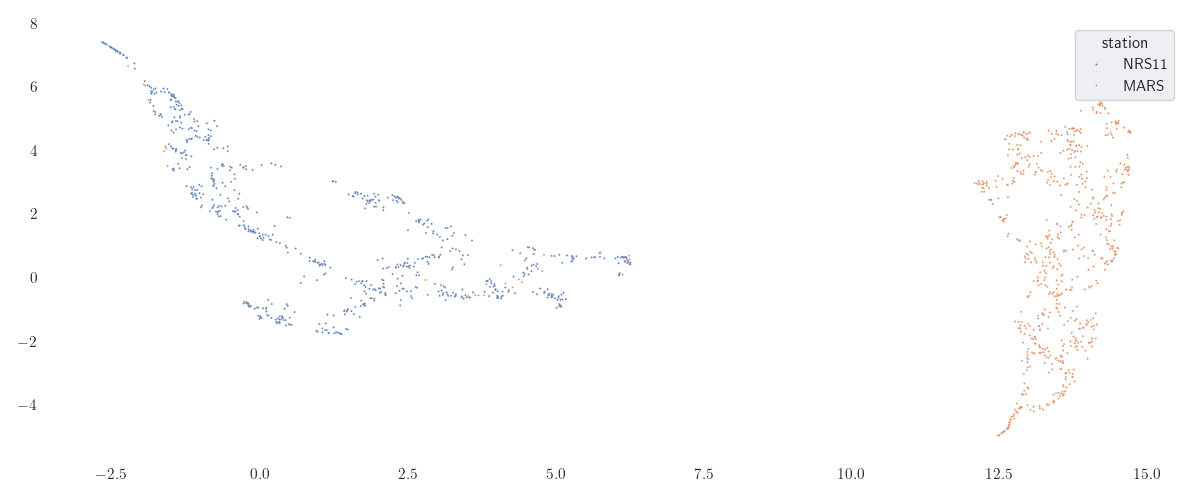

In [27]:
ax = sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],
                     s=2, alpha=0.9, hue=df['station'],
                     legend=True)
ax.set_facecolor('white')
plt.show()

We can perfom another dimension reduction, this time only for one station 

In [28]:
umap_box = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.05)
umap_box.fit(df1[frequency_columns].values)
embedding = umap_box.transform(df1[frequency_columns])

And we can plot it coloring it by hour for example

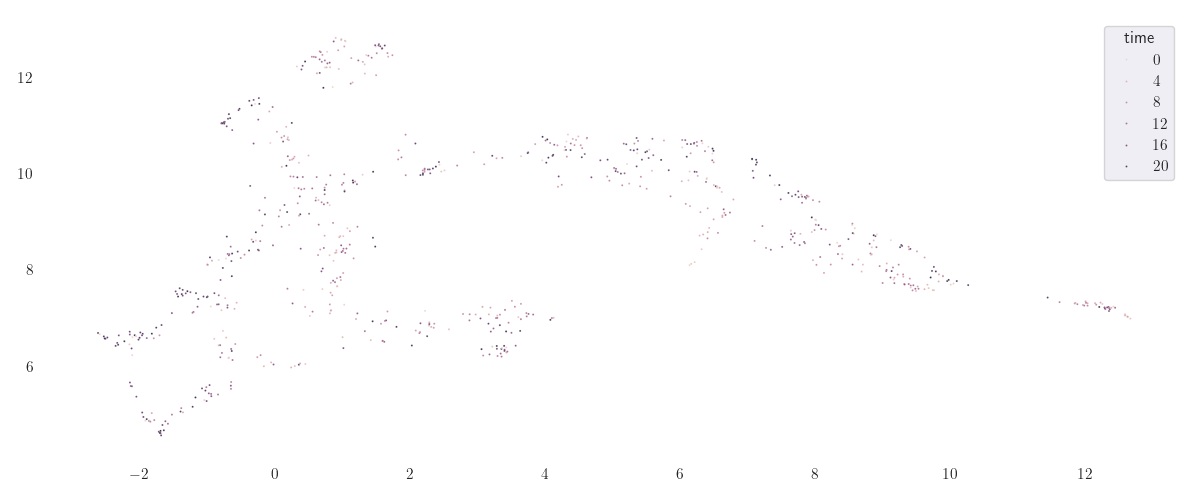

In [29]:
ax = sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],
                     s=2, alpha=0.9, hue=df1.index.hour,
                     legend=True)
ax.set_facecolor('white')
plt.show()

Or by month

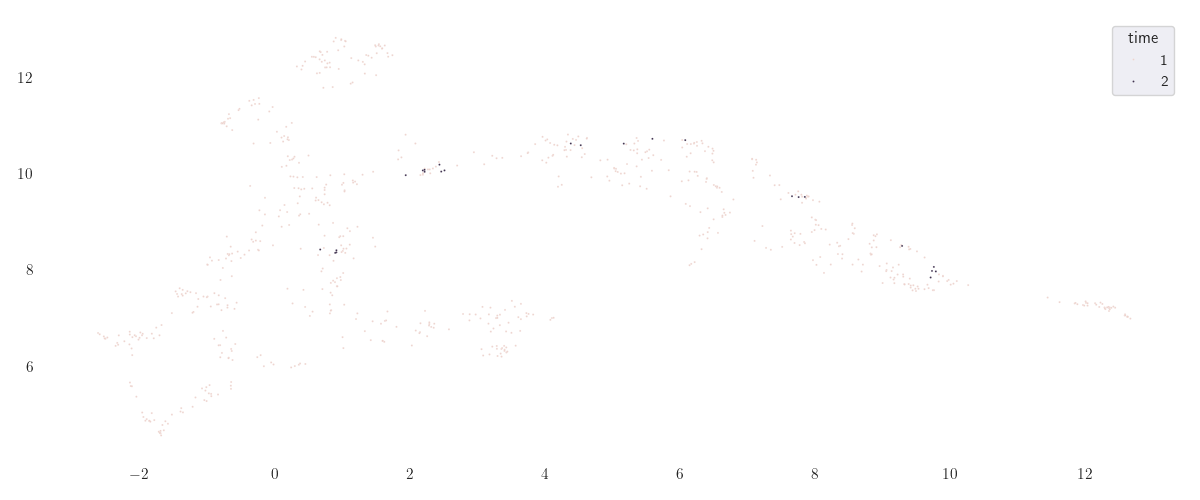

In [30]:
ax = sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],
                     s=2, alpha=0.9, hue=df1.index.month,
                     legend=True)
ax.set_facecolor('white')
plt.show()

In [31]:
umap_box = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.05)
umap_box.fit(df2[frequency_columns].values, y=df2.index.month)
embedding = umap_box.transform(df2[frequency_columns])

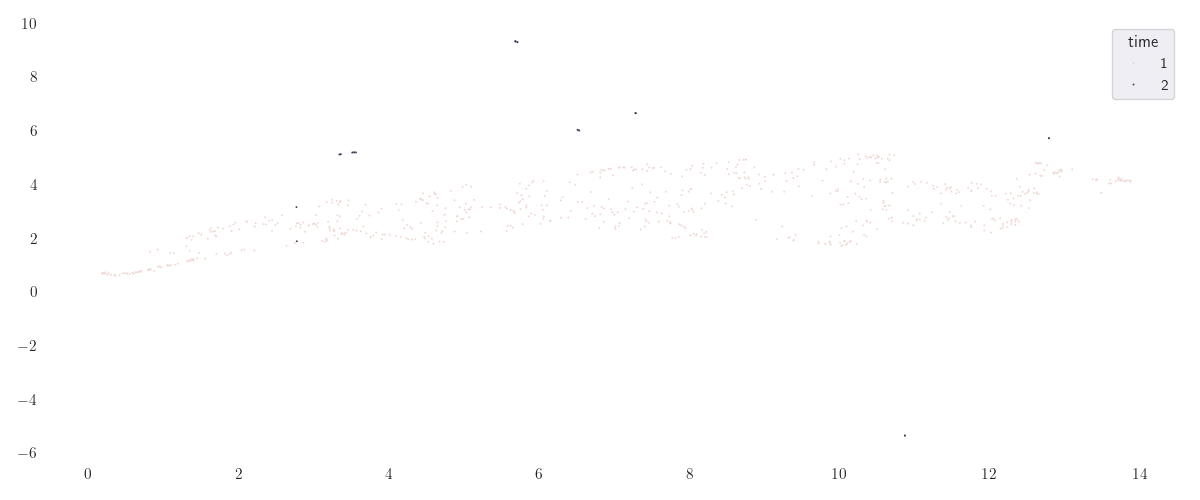

In [32]:
ax = sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],
                     s=2, alpha=0.9, hue=df2.index.month,
                     legend=True)
ax.set_facecolor('white')
plt.show()